<a href="https://colab.research.google.com/github/nimu77/DS-Unit-1-Sprint-3-Linear-Algebra/blob/master/module4-clustering/LS_DS_134_Clustering_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering

# 1) Use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

In [2]:
df = df.drop('diagnosis', axis=1)
df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Let's do it!

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to use the elbow method to decide on the number of clusters to use.


In [3]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


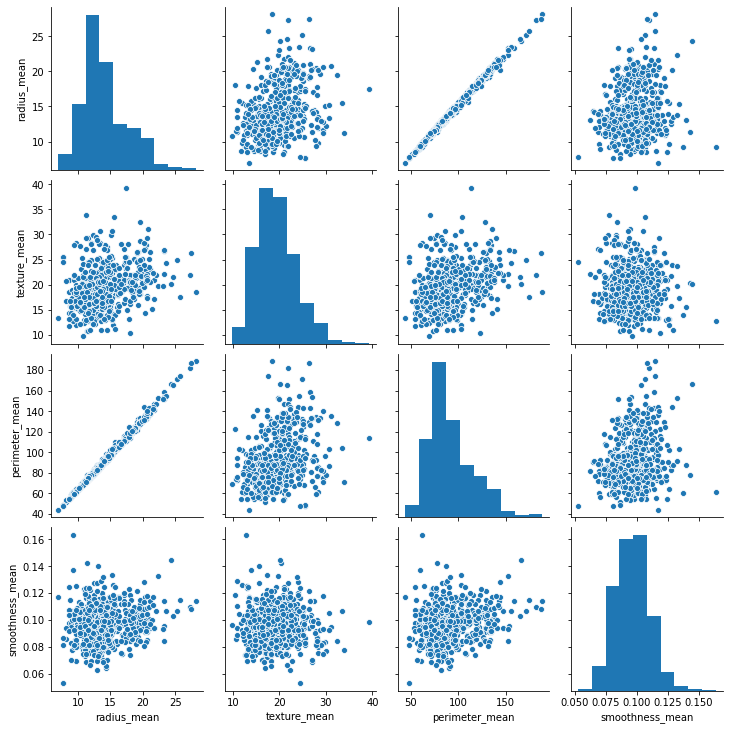

In [4]:
sns.pairplot(df, vars=['radius_mean', 'texture_mean', 'perimeter_mean', 'smoothness_mean'])
plt.show()

In [5]:
# Perform K-Means Clustering on the Dataset
df.isnull().sum()

id                           0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed: 32                569
dtype: i

In [0]:
df= df.drop(['id', 'Unnamed: 32'], axis=1)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


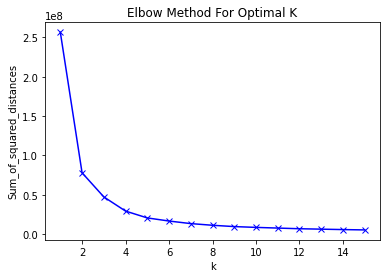

In [8]:
sum_of_squared_distances = []
K = list(range(1, 16))
print(K)

for k in K:
  km = KMeans(n_clusters=k)
  km = km.fit(df)
  sum_of_squared_distances.append(km.inertia_)


plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal K')
plt.show()

In [9]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(df)
labels = kmeans.labels_

print(labels)

[1 1 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0 1
 0 1 1 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0
 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 1 1 

In [10]:
type(labels)

numpy.ndarray

In [11]:
# Add our new labels to the dataframe
new_series = pd.Series(labels)
new_series

0      1
1      1
2      1
3      0
4      1
      ..
564    1
565    1
566    0
567    1
568    0
Length: 569, dtype: int32

In [12]:
type(new_series)

pandas.core.series.Series

In [13]:
df['clusters'] = new_series.values
df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,clusters
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


## Check you work: 

This is something that in a truly unsupervised learning situation **WOULD NOT BE POSSIBLE**. But for educational purposes go back and grab the true diagnosis column (label) from the original dataset. Take your cluster labels and compare them to the original diagnosis column. You can make scatterplots for each to see how they compare or you can calculate a percent accuracy score like: 
\begin{align}
\frac{\text{Num Correct Labels}}{\text{Num Total Observations}}
\end{align}

In [14]:
# Your Code Here
original_df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(original_df.shape)
original_df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [16]:
original_df = original_df.drop(['id', 'Unnamed: 32'], axis=1)
original_df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [17]:
original_df.dtypes

diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst

In [18]:
original_df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [0]:
original_df['diagnosis'] = original_df['diagnosis'].replace({'B': 0, 'M': 1})

In [0]:
original_df['clusters'] = new_series.values
original_df.head()

In [24]:
(original_df['diagnosis'] == original_df['clusters']).value_counts()[1] / len(original_df)

0.8541300527240774

# 2) Perform PCA on your dataset first and *then* use k-means clustering. 

- You need to standardize your data before PCA.
- First try clustering just on PC1 and PC2 so that you can make a scatterplot of your clustering.
- Then use use a scree plot to decide how many principal components to include in your clustering, and use however many principal components you need in order to retain 90% of the variation of the original dataset



In [25]:
##### Your Code Here #####
df_pca = df.copy()
df_pca

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,clusters
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,1
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,1
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,1


In [0]:
df_pca = df.drop('clusters', axis=1)

In [27]:
df_pca.dtypes

radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst       float64
symmetry_worst      

In [28]:
# Principal Component Analysis

# Standardize the Data
# Instantiate a Standard Scaler object

scaler = StandardScaler()

# Use the object to fit_transform our data

X = scaler.fit_transform(df_pca)
print("\n Standardized Data: \n", X)


 Standardized Data: 
 [[ 1.09706398 -2.07333501  1.26993369 ...  2.29607613  2.75062224
   1.93701461]
 [ 1.82982061 -0.35363241  1.68595471 ...  1.0870843  -0.24388967
   0.28118999]
 [ 1.57988811  0.45618695  1.56650313 ...  1.95500035  1.152255
   0.20139121]
 ...
 [ 0.70228425  2.0455738   0.67267578 ...  0.41406869 -1.10454895
  -0.31840916]
 [ 1.83834103  2.33645719  1.98252415 ...  2.28998549  1.91908301
   2.21963528]
 [-1.80840125  1.22179204 -1.81438851 ... -1.74506282 -0.04813821
  -0.75120669]]


In [29]:
# create the PCA instance
pca = PCA()

# fit on data
transformed_data = pca.fit(X)

# access values and vectors
print("\n Eigenvectors: \n", pca.components_)
print("\n Eigenvalues: \n",pca.explained_variance_)


 Eigenvectors: 
 [[ 2.18902444e-01  1.03724578e-01  2.27537293e-01  2.20994985e-01
   1.42589694e-01  2.39285354e-01  2.58400481e-01  2.60853758e-01
   1.38166959e-01  6.43633464e-02  2.05978776e-01  1.74280281e-02
   2.11325916e-01  2.02869635e-01  1.45314521e-02  1.70393451e-01
   1.53589790e-01  1.83417397e-01  4.24984216e-02  1.02568322e-01
   2.27996634e-01  1.04469325e-01  2.36639681e-01  2.24870533e-01
   1.27952561e-01  2.10095880e-01  2.28767533e-01  2.50885971e-01
   1.22904556e-01  1.31783943e-01]
 [-2.33857132e-01 -5.97060883e-02 -2.15181361e-01 -2.31076711e-01
   1.86113023e-01  1.51891610e-01  6.01653628e-02 -3.47675005e-02
   1.90348770e-01  3.66575471e-01 -1.05552152e-01  8.99796818e-02
  -8.94572342e-02 -1.52292628e-01  2.04430453e-01  2.32715896e-01
   1.97207283e-01  1.30321560e-01  1.83848000e-01  2.80092027e-01
  -2.19866379e-01 -4.54672983e-02 -1.99878428e-01 -2.19351858e-01
   1.72304352e-01  1.43593173e-01  9.79641143e-02 -8.25723507e-03
   1.41883349e-01  2.75

In [31]:
# transform data
B = pca.transform(X)
print("\n Projected Data: \n", B)


 Projected Data: 
 [[ 9.19283683e+00  1.94858307e+00 -1.12316616e+00 ... -3.39144536e-02
   4.56477199e-02 -4.71692081e-02]
 [ 2.38780180e+00 -3.76817174e+00 -5.29292687e-01 ...  3.26241827e-02
  -5.68742432e-03 -1.86787626e-03]
 [ 5.73389628e+00 -1.07517380e+00 -5.51747593e-01 ...  4.70258247e-02
   3.14589659e-03  7.50534755e-04]
 ...
 [ 1.25617928e+00 -1.90229671e+00  5.62730526e-01 ... -2.57775589e-03
   6.70621179e-03  3.77041667e-03]
 [ 1.03747941e+01  1.67201011e+00 -1.87702933e+00 ... -6.80863833e-02
  -8.41632764e-02 -2.37828222e-02]
 [-5.47524330e+00 -6.70636791e-01  1.49044308e+00 ... -9.51587894e-03
  -6.09131090e-02 -1.94755854e-02]]


In [32]:
projected_data_with_all_attributes = pd.DataFrame(B)
projected_data_with_all_attributes

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370,-0.398407,-0.157118,-0.877402,0.262955,-0.859014,0.103388,-0.690804,-0.601793,0.745116,-0.265471,-0.549563,-0.133768,0.345565,0.096515,0.068850,0.084519,-0.175256,-0.151020,-0.201503,-0.252585,-0.033914,0.045648,-0.047169
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358,0.240988,-0.711905,1.106995,0.813120,0.157923,-0.943529,-0.653475,0.008975,-0.648809,-0.017212,0.318297,0.247565,-0.114133,-0.077327,-0.094578,-0.217718,0.011290,-0.170510,-0.041129,0.181270,0.032624,-0.005687,-0.001868
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0.097374,0.024066,0.454275,-0.605604,0.124387,-0.410627,0.016680,0.483420,0.325111,0.190918,-0.087975,0.392626,-0.204532,0.311067,-0.060309,-0.074291,0.102762,0.171158,0.004735,0.049569,0.047026,0.003146,0.000751
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429911,1.059565,-1.405440,-1.116975,-1.151514,1.011316,-0.933271,-0.487417,-0.168848,0.051370,0.482634,-0.035875,0.026748,-0.464734,0.434193,-0.203266,-0.124105,0.153430,0.077496,-0.275225,0.183462,0.042484,-0.069295,-0.019937
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213,0.636376,-0.263805,0.377704,0.651360,-0.110515,0.387948,-0.539181,0.310319,-0.152606,0.133142,-0.018714,-0.461436,0.065495,-0.116545,-0.017650,0.139454,-0.005332,0.003062,0.039254,0.032168,-0.034786,0.005038,0.021214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,6.439315,-3.576817,2.459487,1.177314,-0.074824,-2.375193,-0.596130,-0.035471,0.987929,0.256989,-0.062651,0.123342,-0.051723,-0.404290,0.652750,0.147642,0.348266,-0.195214,0.246315,-0.404446,0.006888,-0.067000,0.088590,0.107898,0.219520,-0.122900,0.159198,0.009853,0.007119,-0.001415
565,3.793382,-3.584048,2.088476,-2.506028,-0.510723,-0.246710,-0.716326,-1.113360,-0.105207,-0.108632,0.244804,0.222753,-0.192637,0.015555,-0.069975,-0.138184,0.293495,-0.109046,0.182521,-0.229947,-0.009802,0.019563,-0.055405,0.086135,0.001197,0.065889,-0.068512,-0.023575,-0.027486,-0.010419
566,1.256179,-1.902297,0.562731,-2.089227,1.809991,-0.534447,-0.192758,0.341887,0.393917,0.520877,-0.840512,0.096473,0.157418,0.285691,0.090998,-0.232648,-0.065615,0.021108,0.042020,-0.081420,-0.036592,0.063352,-0.200312,-0.044819,0.002429,0.007095,-0.023691,-0.002578,0.006706,0.003770
567,10.374794,1.672010,-1.877029,-2.356031,-0.033742,0.567936,0.223082,-0.280239,-0.542035,-0.089296,-0.178628,-0.697461,1.225195,0.218698,0.229591,-0.061047,-0.168514,-0.306874,-0.310569,0.173216,0.140648,-0.042478,0.168820,-0.195969,0.377830,-0.198192,-0.027409,-0.068086,-0.084163,-0.023783


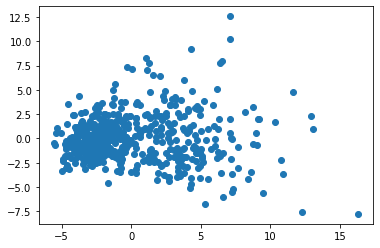

In [33]:
plt.scatter(projected_data_with_all_attributes[0], projected_data_with_all_attributes[1])
plt.show()

In [0]:
# create the PCA instance to capture 90% of the dataset
pca = PCA(.9)
# fit on data
transformed_data = pca.fit(X)

In [0]:
# Define scree plot function
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

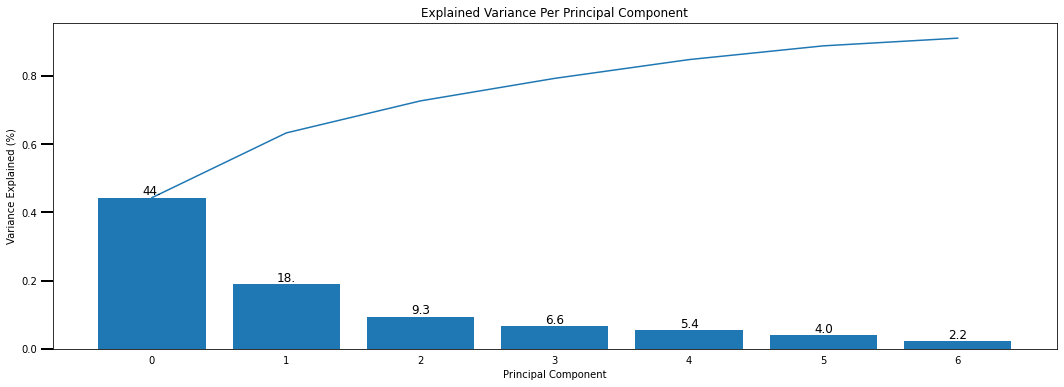

In [36]:
scree_plot(pca)

In [37]:
np.sum(pca.explained_variance_ratio_)

0.9100953006967308

In [38]:
# # transform data
C = pca.transform(X)
print("\n Projected Data: \n", C)


 Projected Data: 
 [[ 9.19283683  1.94858307 -1.12316616 ... -1.19511012  1.41142445
   2.15936987]
 [ 2.3878018  -3.76817174 -0.52929269 ...  0.62177498  0.02865635
   0.01335809]
 [ 5.73389628 -1.0751738  -0.55174759 ... -0.1770859   0.54145215
  -0.66816648]
 ...
 [ 1.25617928 -1.90229671  0.56273053 ...  1.80999133 -0.53444719
  -0.19275823]
 [10.37479406  1.67201011 -1.87702933 ... -0.03374193  0.56793647
   0.22308167]
 [-5.4752433  -0.67063679  1.49044308 ... -0.18470331  1.61783736
   1.69895156]]


In [39]:
C.shape

(569, 7)

In [0]:
df_PC_8 = pd.DataFrame(C)

In [44]:
df_PC_8.shape

(569, 7)

In [45]:
df_PC_8.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7']
df_PC_8.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429911
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213


In [46]:
# from sklearn.cluster import KMeans 
kmeans = KMeans(n_clusters=2)
kmeans.fit(df_PC_8)
labels = kmeans.labels_

print(labels)

[0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 1
 1 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1
 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1
 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 0
 0 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1
 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 0 1 0 1 1 1 1 0 

In [47]:
# Add our new labels to the dataframe
new_series = pd.Series(labels)
df_PC_8['new_clusters'] = new_series.values

df_PC_8.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,new_clusters
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370,0
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358,0
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429911,0
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213,0


In [49]:
original_df['new_clusters'] = new_series.values
original_df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,clusters,new_clusters
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1,0
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1,0
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1,0
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0,0
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1,0


In [53]:
(original_df['diagnosis'] == original_df['new_clusters']).value_counts()[0] / len(original_df)

0.9103690685413005

## Check your work: 

- Compare your PC1, PC2 clustering scatterplot to the clustering scatterplots you made on the raw data
- Calculate accuracy scores for both the PC1,PC2 Principal component clustering and the 90% of explained variance clustering.

How do your accuracy scores -when preprocessing the data with PCA- compare to the accuracy when simply clustering on the raw data?

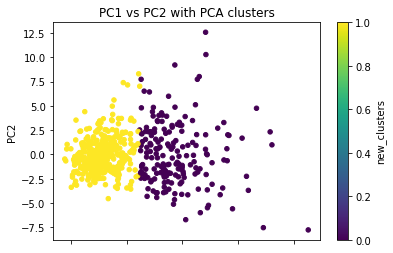

In [58]:
df_PC_8.plot.scatter('PC1', 'PC2', c='new_clusters', colormap='viridis')
plt.title("PC1 vs PC2 with PCA clusters");

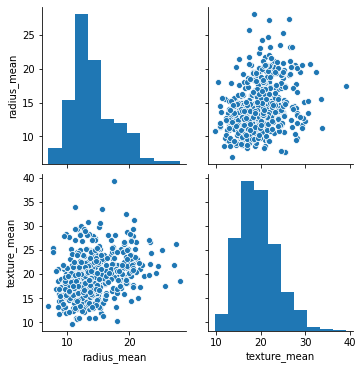

In [63]:
sns.pairplot(df, vars=['radius_mean', 'texture_mean'])
plt.show()

#### The preprocessing data with PCA is accurate by more than 6 percent compared to simply clustering in the raw data.

# Stretch Goals:

- Study for the Sprint Challenge
- Work on your Data Storytelling Project